<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw10_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 10

Pre-trained large language models (LLMs) compress knowledge from vast amounts of text, but in practice they often need additional fine-tuning to perform well on specific downstream tasks. Fine-tuning can be done by updating all of a model’s parameters (full-model fine-tuning) or by modifying only a small subset, a strategy known as parameter-efficient fine-tuning (PEFT), which is typically preferred for its computational and memory savings.

Low-Rank Adaptation (LoRA) is a popular option for PEFT, because it introduces small trainable matrices (A and B) that adjust a model’s generation without altering most existing parameters. In this homework, we will fine-tune a pretrained LLM, HuggingFace’s SmolLM2, on a downstream dataset using both full-model training and LoRA. After evaluating the full-model version in Part 1, we will implement our own LoRA-based fine-tuning in Part 2. For more background on LoRA, you may find it helpful to review the original paper: https://arxiv.org/pdf/2106.09685


**!NOTE!**
* Please run any training related code under the `__name__ == '__main__'` block. This prevents any time-out when running your solution on Markus. Basically, any code that is not a python function should go under the `__name__ == '__main__'` block.

In [1]:
import torch
import numpy as np
import torch.nn as nn
from typing import List

if __name__ == '__main__':

    !pip install datasets # comment out when submitting
    !pip install evaluate # comment out when submitting

    import os
    import torch
    import random
    import evaluate
    import requests
    import numpy as np
    import pandas as pd
    import torch.nn as nn
    from io import BytesIO
    from typing import List

    from tqdm.auto import tqdm
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForLanguageModeling
    from transformers import get_scheduler, get_linear_schedule_with_warmup
    from datasets import load_dataset
    from torch.optim import AdamW
    from torch.utils.data import DataLoader
    from huggingface_hub import HfApi, hf_hub_download, hf_hub_url, login

In [2]:
if __name__ == '__main__':
    def in_colab():
        try:
            import google.colab
            return True
        except ImportError:
            return False

    if in_colab():
        from google.colab import drive
        drive.mount('/content/drive')
        MODEL_SAVE_PATH = '/content/drive/MyDrive/CSC413'
    else:
        MODEL_SAVE_PATH = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting up

HuggingFace’s **SmolLM2-135M** is a pretrained language model with 135 million parameters, trained using a next-token prediction objective in which the model learns to generate the next tokens in a sequence given some input text.  However, as you will soon observe, the base model is not yet capable of producing clean, well-structured answers in response to user prompts.

To adapt the model to engage in multi-turn dialogue and better follow instructions, we will fine-tune it on a subset of **SmolTalk**, a synthetic dataset created specifically to improve the model's instruction following ability (fine-tuning an LLM on such dataset is often referred to as "instruction-tuning" in practice). SmolTalk is the same dataset used to produce SmolLM2’s Instruct variants, and our fine-tuning will demonstrate how instruction tuning improves conversational and response generation ability.

Finally, you will **load your fine-tuned models to HuggingFace**. To do this, you should [sign up](https://huggingface.co/join) if you don't have an account already, and [set up an access token](https://huggingface.co/docs/hub/en/security-tokens). While this is not the only approach, one way you can easily push your trained model on Colab:

```
if __name__ == '__main__':
    !huggingface-cli login # paste your token when prompted
    your_finetuned_model.push_to_hub('your_username/model_repo_name_you_choose')
    tokenizer.push_to_hub('your_username/model_repo_name_you_choose')
```

In [3]:
######################## DO NOT MODIFY ########################
# Download the model and tokenizer
if __name__ == '__main__':
    checkpoint = "HuggingFaceTB/SmolLM2-135M"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    tokenizer.pad_token = '<|pad_token|>'
    print(tokenizer.eos_token)
    print(tokenizer.bos_token)
    print(tokenizer.pad_token)

    model_full = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
    print(model_full)

    inputs = tokenizer.encode("Gravity is", return_tensors="pt").to(device)
    outputs = model_full.generate(inputs)
    print(tokenizer.decode(outputs[0]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<|endoftext|>
<|endoftext|>
<|pad_token|>


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): Lla

In [4]:
######################## DO NOT MODIFY ########################
# Download the dataset
if __name__ == '__main__':
    ds = load_dataset("HuggingFaceTB/smoltalk", "everyday-conversations")
    print(ds['train'][0])

{'full_topic': 'Travel/Vacation destinations/Beach resorts', 'messages': [{'content': 'Hi there', 'role': 'user'}, {'content': 'Hello! How can I help you today?', 'role': 'assistant'}, {'content': "I'm looking for a beach resort for my next vacation. Can you recommend some popular ones?", 'role': 'user'}, {'content': "Some popular beach resorts include Maui in Hawaii, the Maldives, and the Bahamas. They're known for their beautiful beaches and crystal-clear waters.", 'role': 'assistant'}, {'content': 'That sounds great. Are there any resorts in the Caribbean that are good for families?', 'role': 'user'}, {'content': 'Yes, the Turks and Caicos Islands and Barbados are excellent choices for family-friendly resorts in the Caribbean. They offer a range of activities and amenities suitable for all ages.', 'role': 'assistant'}, {'content': "Okay, I'll look into those. Thanks for the recommendations!", 'role': 'user'}, {'content': "You're welcome. I hope you find the perfect resort for your v

In [5]:
############ paste your HuggingFace access token here! ############
if __name__ == '__main__':
    login()

# Part 1: Full-model fine-tuning on instruction dataset (2 point)

Before we implement the LoRA fine-tuning workflow, we will first establish a baseline using **full-model fine-tuning**. During instruction fine-tuning, it is common to apply a template to the dataset to format inputs and outputs into a consistent conversational structure that the model can learn from. This templated dataset is then used to fine-tune the LLM.

The base-model is trained to predict the next token and may not inherently understand what a “user message” or an “assistant response” is. Templates impose a conversation structure to the text, from whcih the model is trained to predict when the assistant's turn is and what style of output to produce. For instance:

```
<|user|>: What is 1+1?
<|assistant|>: It is 2.
```

In this section, you will write your own functions required to fine-tune the model (e.g. processing the original dataset, creating the training loop or using a Trainer), similar to what you have implemented in previous assignments.

We will fine-tune the model on the *everydata-conversation* split of the SmolTalk dataset, which contains multi-turn conversations between a user and an assistant across a wide range of topics (sports, fashion, health, entertainment, and more). After fine-tuning, you will see how even a simple instruction-tuning approach can significantly improve generation quality.

## 1.a Convert the dataset to chat template (0.5 point)

**TODO**
* Complete the apply_my_chat_template() function to convert a raw text data into a chat-templated format. You can define your own chat template, or look up any common chat templates used in practice.

Given a list of user-assistant messages, your function should convert it into a single formatted string. For instance:
```
user_input = [{'content': 'how are you?', 'role': 'user'},
              {'content': 'I'm good, thanks! And you?', 'role': 'assistant'}
]
templated_output = apply_my_chat_template(user_input)
print(templated_output)
-----------------------------------------
<|user|> How are you?
<|assistant|> I'm good, thanks! And you?
-----------------------------------------
```

In [6]:
def apply_my_chat_template(messages: List) -> str:

    formatted = ""
    ################ YOUR CODE ################
    # TODO: given a list user-assistant interactions, create a formatted string
    #       with "user" and "assistant" headers
    for message in messages:
        role = message['role']
        content = message['content']
        formatted += f"<|{role}|> {content}\n"

    return formatted.strip()
    ###########################################


In [7]:
if __name__ == '__main__':
    ############ TESTING THE TEMPLATE CODE ############
    formatted_input = apply_my_chat_template([{'content': 'hi there!', 'role': 'user'},
                                              {'content': 'hi, how is it going?', 'role':'assistant'}])
    print(formatted_input)

<|user|> hi there!
<|assistant|> hi, how is it going?


## 1.b Fine-tuning the model (1.5 point)

Unlike LLMs with a classification head, which output one of a fixed set of labels (such as the model used in Homework 8), SmolLM2 generates open-ended text responses. There are multiple ways to evaluate the quality of such generative models. In this assignment we will use the validation loss after fine-tuning as the quantitative measure of model quality. In addition, you will design a set of custom prompts to qualitatively compare the model’s responses before and after fine-tuning.

Your fine-tuned model will be evaluated using the check_validation_loss() function. The function takes your fine-tuned model, apply_my_template() function, and the original dataset.

**TODO**
* Define your **custom prompts (10 total)** used evaluate the model generation quality.
* Complete the **count_trainable_parameter()** function to count the number of tunable parameters.
* Set up your own **training function** to run training. Achieve validation loss < 0.5

In [8]:
##################### DO NOT MODIFY THE CODE! #####################
def check_validation_loss(model, tokenizer, my_template_function, dataset):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenized_dataset = dataset.map(lambda x: tokenizer(my_template_function(x['messages'])))
    tokenized_dataset = tokenized_dataset.map(lambda x: {"labels": x['input_ids']})

    tokenized_dataset = tokenized_dataset.select_columns(['input_ids','labels','attention_mask'])
    tokenized_dataset.set_format("torch")

    valid_dataloader = DataLoader(tokenized_dataset['test'],
                                  batch_size=1)

    model.to(device)
    batch_loss = []
    with torch.no_grad():
        for batch in valid_dataloader:
            out = model(**{k:v.to(device) for k, v in batch.items()})
            batch_loss.append(out.loss)

    avg_loss = sum(batch_loss) / len(batch_loss)

    return avg_loss

In [9]:
def count_trainable_parameters(model):
    ########################### YOUR CODE ###########################
    # TODO: count the total number of tunable parameters
    # HINT: for the default SmolLM2-135M, the function returns around ~135M.
    #       for LoRA training, this value is much smaller.
    total_params = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
    return total_params
    #############################################################

In [10]:
########################### YOUR PROMPTS ###########################
# TODO: define 10 user prompts to assess the model quality
YOUR_PROMPTS = [
                [{'role':'user', 'content': 'Why is the sky blue?'}],
                [{'role':'user', 'content': 'What is the capital of France?'}],
                [{'role':'user', 'content': 'Explain photosynthesis in simple terms.'}],
                [{'role':'user', 'content': 'How do airplanes fly?'}],
                [{'role':'user', 'content': 'What causes seasons on Earth?'}],
                [{'role':'user', 'content': 'Tell me about the water cycle.'}],
                [{'role':'user', 'content': 'What is artificial intelligence?'}],
                [{'role':'user', 'content': 'How does a microwave oven work?'}],
                [{'role':'user', 'content': 'What are the main causes of climate change?'}],
                [{'role':'user', 'content': 'Describe the process of evolution.'}],
               ]

Here, write any training code necessary to run full model fine-tuning of SmolLM2 on the instruction dataset. Make sure to put your code block under `if __name__ == '__main__': ` to avoid having the code running during the autograding.

In [11]:
################### CHECK THE VALIDATION LOSS ###################
if __name__ == '__main__':
    # Fine tune the model
    MAX_LEN = 256
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenized_train = ds.map(
        lambda x: tokenizer(
              apply_my_chat_template(x['messages']),
              truncation=True,
              padding="max_length",
              max_length=MAX_LEN
          )
        )
    tokenized_train = tokenized_train.map(lambda x: {"labels": x['input_ids']})

    tokenized_train = tokenized_train.select_columns(['input_ids','labels','attention_mask'])
    tokenized_train.set_format("torch")

    train_dataloader = DataLoader(tokenized_train['train'], batch_size=16)

    optimizer = AdamW(
        [p for p in model_full.parameters() if p.requires_grad],
        lr=5e-5
    )

    num_epochs = 3
    num_training_steps = num_epochs * len(train_dataloader)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs):
      model_full.train()
      for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_full(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

      # After each epoch, check validation loss
      val_loss = check_validation_loss(model_full, tokenizer, apply_my_chat_template, ds)
      print(f"Epoch {epoch+1}: validation loss = {val_loss.item():.4f}")


    full_valid_loss = check_validation_loss(model_full, tokenizer, apply_my_chat_template, ds)
    print(full_valid_loss)

Epoch 1: validation loss = 0.9979
Epoch 2: validation loss = 0.9705
Epoch 3: validation loss = 0.9654
tensor(0.9654, device='cuda:0')


In [12]:
#################### CHECK MODEL GENERATION QUALITY BEFORE/AFTER FINE-TUNING ####################
if __name__ == '__main__':
    for idx, p in enumerate(YOUR_PROMPTS):
        templated_ipnut = apply_my_chat_template(p) + '\n<|im_start|><|assistant|>: '
        tokenized_input = tokenizer(templated_ipnut, return_tensors='pt')
        out = model_full.generate(**{k:v.to(device) for k, v in tokenized_input.items()}, max_new_tokens=50)

        print(f"{idx}")
        print(">>> Raw input text: ", p)
        print(">>> Templated output: ", templated_ipnut)
        print(">>> Model full output: \n" , tokenizer.decode(out[0]))
        print('\n')

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0
>>> Raw input text:  [{'role': 'user', 'content': 'Why is the sky blue?'}]
>>> Templated output:  <|user|> Why is the sky blue?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Why is the sky blue?
<|im_start|><|assistant|>:  The sky is blue because of the way light is scattered by the air.

### 2.2.2.3.1: What is the color of the sky?

### 2.2.2.3.1




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1
>>> Raw input text:  [{'role': 'user', 'content': 'What is the capital of France?'}]
>>> Templated output:  <|user|> What is the capital of France?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What is the capital of France?
<|im_start|><|assistant|>: 27 rue de l'Etoile

### What is the capital of France?

The capital of France is Paris.

### What is the capital of France in 2023?

The capital of




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


2
>>> Raw input text:  [{'role': 'user', 'content': 'Explain photosynthesis in simple terms.'}]
>>> Templated output:  <|user|> Explain photosynthesis in simple terms.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Explain photosynthesis in simple terms.
<|im_start|><|assistant|>: 1. Plants use sunlight to make food. 2. Plants use water and air to make food. 3. Plants use sunlight to make food.

### 2. What is photosynthesis?

Photosynthesis is the process by which




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


3
>>> Raw input text:  [{'role': 'user', 'content': 'How do airplanes fly?'}]
>>> Templated output:  <|user|> How do airplanes fly?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> How do airplanes fly?
<|im_start|><|assistant|>: 1. They fly by using a wing that is shaped like a bird's wing. 2. They use a propeller to turn the wing. 3. They use a tail to help control the flight. 4. They use a control surface




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


4
>>> Raw input text:  [{'role': 'user', 'content': 'What causes seasons on Earth?'}]
>>> Templated output:  <|user|> What causes seasons on Earth?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What causes seasons on Earth?
<|im_start|><|assistant|>: 1. The Earth's tilt causes the seasons. 2. The tilt of the Earth causes the seasons. 3. The tilt of the Earth causes the seasons. 4. The tilt of the Earth causes the seasons. 5. The




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


5
>>> Raw input text:  [{'role': 'user', 'content': 'Tell me about the water cycle.'}]
>>> Templated output:  <|user|> Tell me about the water cycle.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Tell me about the water cycle.
<|im_start|><|assistant|>:  The water cycle is the process by which water is transformed from one state to another. It includes evaporation, condensation, precipitation, and runoff.

### Step 2: Understand the Water Cycle

The water cycle is a continuous process that involves




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6
>>> Raw input text:  [{'role': 'user', 'content': 'What is artificial intelligence?'}]
>>> Templated output:  <|user|> What is artificial intelligence?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What is artificial intelligence?
<|im_start|><|assistant|>: 1. A computer program that can learn and improve from experience. 2. A computer program that can perform tasks that would normally require human intelligence, such as speech recognition or decision-making. 3. A computer program that can perform tasks that




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


7
>>> Raw input text:  [{'role': 'user', 'content': 'How does a microwave oven work?'}]
>>> Templated output:  <|user|> How does a microwave oven work?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> How does a microwave oven work?
<|im_start|><|assistant|>: 1. The microwave oven heats up food by using microwaves. 2. The microwaves are absorbed by the food and heat it up. 3. The food is then cooked. 4. The microwave oven is a great way to cook food quickly




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


8
>>> Raw input text:  [{'role': 'user', 'content': 'What are the main causes of climate change?'}]
>>> Templated output:  <|user|> What are the main causes of climate change?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What are the main causes of climate change?
<|im_start|><|assistant|>: 1. The greenhouse effect. 2. The burning of fossil fuels. 3. The release of greenhouse gases from deforestation. 4. The release of methane from the ocean floor. 5. The release of carbon dioxide from the atmosphere.


9
>>> Raw input text:  [{'role': 'user', 'content': 'Describe the process of evolution.'}]
>>> Templated output:  <|user|> Describe the process of evolution.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Describe the process of evolution.
<|im_start|><|assistant|>: 1. What is the process of evolution?

evolution<|assistant|>: 2. What is the process of evolution?

evolution<|assistant|>: 3. What is the process of evolution?





In [13]:
############### TO SUBMIT ###############
YOUR_HF_USER_NAME = "afra7778"
YOUR_FULL_MODEL_REPO_NAME = "smollm2-finetuned-chat-instruct-full"
#########################################

In [14]:
######### SAVE THE MODEL WEIGHTS #########
if __name__ == '__main__':

    # first, save locally
    model_full.save_pretrained(f"{MODEL_SAVE_PATH}/{YOUR_FULL_MODEL_REPO_NAME}")
    tokenizer.save_pretrained(f"{MODEL_SAVE_PATH}/{YOUR_FULL_MODEL_REPO_NAME}")

    # then upload to huggingface
    api = HfApi()
    api.create_repo(YOUR_FULL_MODEL_REPO_NAME, exist_ok=True, repo_type="model")
    api.upload_folder(
        folder_path=f"{MODEL_SAVE_PATH}/{YOUR_FULL_MODEL_REPO_NAME}",
        repo_id=f"{YOUR_HF_USER_NAME}/{YOUR_FULL_MODEL_REPO_NAME}"
    )

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ct-full/model.safetensors:   0%|          | 12.0kB /  538MB            

# Part 2: Motivating low-rank adaptation (LoRA) training (0.5 point)

When we fine-tune a pretrained model, we are effectively learning an update to the model’s weight matrices:
$$W' = W + \Delta W$$
where $W$ is the pretrained weights (frozen) and $\Delta W $ is the learned task-specific update.

Instead of learning a full matrix $\Delta W \in \mathbb{R}^{d \times k}$,
LoRA assumes that this update has low intrinsic rank.
That is, we can approximate:

$$\Delta W = B A$$

where $A \in \mathbb{R}^{r \times k}$, $B \in \mathbb{R}^{d \times r}$, and $r \ll \min(d, k)$ (the *rank* of the update).
The model’s forward pass becomes:
   $
   y = (W + s \cdot B A) x
   $,
where $s$ is a scaling factor ($\alpha$ / r) that balances the LoRA update magnitude.

In this section, you will check if this assumption indeed holds by analyzing the $\Delta W$ between the base model and its fine-tuned version.

**TODO**
* Implement the reconstruction_err() function, which computes the reconstruction error of a matrix when it is approximated using its top-rank components. This helps us analyze whether the LoRA's low-rank assumption always holds. If it does not, what does this implies for the performance of LoRA fine-tuning?

In [15]:
################## DO NOT CHANGE ##################
def plot_reconstruction_error(df):
    ncols=3
    nrows=2
    f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,6))

    num_lines = 30
    cmap = cm.get_cmap("viridis")

    for idx, target_module in enumerate(['k_proj','q_proj','o_proj','v_proj','up_proj','gate_proj']):
        for i, col in enumerate([c for c in df.columns if target_module in c]):
            color = cmap(i / (num_lines - 1))
            axes[idx//3][idx%3].plot(df['rank'], df[col], color=color, label=col, marker='.')
        axes[idx//3][idx%3].set_title(target_module)

    plt.show()

In [16]:
def reconstruction_err(W, r):

    reconstruction_error = None

    ############### YOUR CODE ###############
    # TODO:
    # 1. Perform SVD on the matrix W and compute its best rank-r approximation
    #    by reconstructing W' using the top-r singular values and corresponding vectors.
    # 2. Return the reconstruction error as the Frobenius norm between W and W', ||W - W'||_F
    # NOTE: 1. Use torch instead of numpy to perform svd
    #       2. When given r > rank of the matrix, use r=matrix rank to approximate W' !

    # Perform SVD
    U, S, Vt = torch.linalg.svd(W, full_matrices=False)

    # Ensure r doesn't exceed the actual rank
    actual_rank = min(r, S.shape[0])

    # Reconstruct using top-r singular values
    W_approx = U[:, :actual_rank] @ torch.diag(S[:actual_rank]) @ Vt[:actual_rank, :]

    # Compute Frobenius norm of the difference
    reconstruction_error = torch.linalg.norm(W - W_approx, ord='fro')
    #########################################

    return reconstruction_error

We are now going to load the base model and the model you have just fine-tuned to compute the $\Delta W$ between the two models. Then, you will analyze whether $\Delta W$ indeed has low intrinsic dimensionality by

1. computing the reconstruction error of $\Delta W$ when it is approximated using its top-r components, and
2. plotting how the error converges towards 0 as r increases.

Does the plot imply that some modules / layers have higher rank than others?

In [17]:
if __name__ == '__main__':

    # load the base model and the model we trained!
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model1 = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
    model2 = AutoModelForCausalLM.from_pretrained(f"{YOUR_HF_USER_NAME}/{YOUR_FULL_MODEL_REPO_NAME}")

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

/tmp/ipython-input-424772821.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


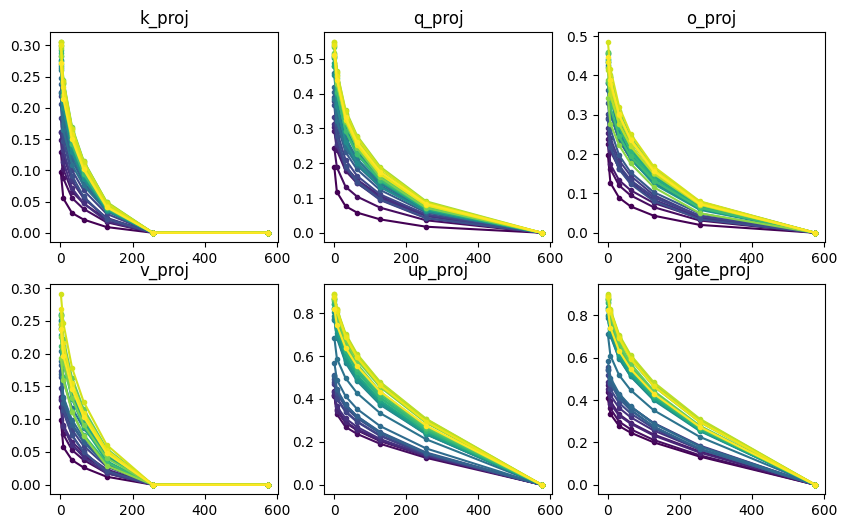

In [18]:
################ VISUALIZATION CODE (could take a few minutes to run) ################
if __name__ == '__main__':
    # To visualize the reconstruction error
    d = {}
    for name, p in model1.named_parameters():
        if 'self_attn' in name or 'mlp' in name:
            w1 = model1.state_dict()[name]
            w2 = model2.state_dict()[name]
            d[name] = {}
            for r in [1, 8, 32, 64, 128, 256, 576]:
                w_delta = w1 - w2
                d[name][r] = reconstruction_err(w_delta, r)

    # create a dataframe
    df = pd.DataFrame(d).reset_index().rename(columns={'index':'rank'})

    # plot; earlier layers (close to 0) have darker colors
    plot_reconstruction_error(df)

# Part 3: LoRA fine-tuning (4 points)


In this section, you will implement parameter-efficient training using LoRA. You will define a custom LoRA layer and attach it to each target module in the model. During training, only the LoRA parameters will be updated while the original model weights remain frozen. The choice of rank (*r*) plays an important role in both performance and efficiency.

How does the number of trainable parameters change as we vary the rank? Is the model performance affected? To explore this trade-off, you can perform a hyperparameter sweep over different values of *r* to determine which setting offers the best balance between performance and efficiency.

## 3.a Create a LoRA model by injecting a custom LoRA layer (1 point)


When we fine-tune a pretrained model, we are effectively learning an update to the model’s weight matrices:
$$W' = W + \Delta W$$
where $W$ is the pretrained weights (frozen) and $\Delta W $ is the learned task-specific update.

Instead of learning a full matrix $\Delta W \in \mathbb{R}^{d \times k}$,
LoRA assumes that this update has low intrinsic rank.
That is, we can approximate:

$$\Delta W = B A$$

where $A \in \mathbb{R}^{r \times k}$, $B \in \mathbb{R}^{d \times r}$, and $r \ll \min(d, k)$ (the *rank* of the update).
The model’s forward pass becomes:
   $
   y = (W + s \cdot B A) x
   $,
where $s$ is a scaling factor ($\alpha$ / r) that balances the LoRA update magnitude.


In this section, define a custom linear layer for LoRA. It should 1. initialize the A and B matrices, and 2. implement a forward pass that applies the LoRA update to the original layer output.


**TODO**
* Complete the LoRALinear class, which creates low-rank A and B matrices and  added the LoRA weights applied output to the original linear layer’s output.

In [26]:
if __name__ == '__main__':
    checkpoint = "HuggingFaceTB/SmolLM2-135M"
    model_lora  = AutoModelForCausalLM.from_pretrained(checkpoint)

In [27]:
class LoRALinear(nn.Module):
    def __init__(self,
                 base_layer: nn.Linear,
                 in_features: int,
                 out_features: int,
                 r: int, alpha: int):
        super().__init__()
        self.base_layer = base_layer
        self.r = r
        self.alpha = alpha
        self.scaling = self.alpha / self.r

        ################# YOUR CODE #################
        # TODO: LoRA parameters
        #       randomly initialize A matrix
        #       then initialize B matrix as 0 matrix
        self.A = nn.Parameter(torch.randn(r, in_features))
        self.B = nn.Parameter(torch.zeros(out_features, r))
        #############################################

    def forward(self, x):

        ################# YOUR CODE #################
        # NOTE: LoRALinear(x) shape should be the same as
        #       base_layer(x) shape
        base_output = self.base_layer(x)

        # Compute LoRA adaptation: x @ A^T @ B^T scaled by alpha/r
        lora_output = (x @ self.A.T @ self.B.T) * self.scaling

        return base_output + lora_output
        #############################################

## 3.b Inject the custom layer into the base model (1 point)

Inject the custom LoRA layer into the base model by iterating over its modules and replacing each target linear layer with a LoRALinear module.

**TODO**
* Complete **replace_target_with_lora_layer()** to  locate each target module and replace it with a LoRALinear instance containing the LoRA A and B matrices.

In [28]:
def replace_target_with_lora_layer(model,
                                   r: int,
                                   alpha: int,
                                   target_modules=['q_proj','k_proj','v_proj','o_proj']) -> None:

    for name, m in model.named_modules():
        layer_name = name.split('.')[-1]
        if layer_name in target_modules:
            ####################### YOUR CODE #######################
            # TODO: iterate through the model modules to find the target modules
            #       then replace it with the LoRALinear
            # HINT: Once you find the target module and its parent module,
            #       you can replace target module using setattr(parent_module, target_module_name, your_LoRALinear)
            # Get parent module
            parent_name = '.'.join(name.split('.')[:-1])
            if parent_name:
                parent = dict(model.named_modules())[parent_name]
            else:
                parent = model

            # Get the original layer
            original_layer = m

            # Create LoRA layer
            lora_layer = LoRALinear(
                base_layer=original_layer,
                in_features=original_layer.in_features,
                out_features=original_layer.out_features,
                r=r,
                alpha=alpha
            )

            # Replace the layer
            setattr(parent, layer_name, lora_layer)
            ##########################################################

After injecting the LoRALinear layer to the target modules, the following for loop should run without an error:

```
replace_target_with_lora_layer(model_lora,
                                r=RANK,
                                alpha=ALPHA,
                                target_modules=TARGET_MODULES)


for name, m in model_lora.named_modules():
    layer_name = name.split('.')[-1]
    if layer_name in TARGET_MODULES:
        if not isinstance(dict(model_lora.named_modules())[name], LoRALinear):
          print("Incorrect!")
          break
```

## 3.c Freeze the base model weights for parameter-efficient fine-tuning (0.5 point)

Finally, ensure that only the LoRA A and B matrices remain trainable by freezing all other model parameters.

**TODO**
* Complete **set_requires_grad_for_lora()** so that only the LoRA parameters require gradients, while all base model weights are frozen.


In [29]:
def set_requires_grad_for_lora(model):

    for name, p in model.named_parameters():
        ####################### YOUR CODE #######################
        # TODO: Freeze the base model weight, and only set requires_grad=True
        #       for A and B matrices
        if '.A' in name or '.B' in name:
            p.requires_grad = True
        else:
            p.requires_grad = False
        ##########################################################

## 3.d Train LoRA model (1.5 point)

Fine-tune the LoRA model on the dataset. Do the same learning rate and number of epochs used for full-model fine-tuning still work here? If not, consider varying the learning rates and LoRA ranks to find the best configuration.

**TODO**
* **Fine-tune the LoRA model** on the everyday-chat dataset. Achieve validation loss < 0.5.
* Compare the LoRA-fine-tuned model with the full fine-tuned model. Which one achieves lower validation loss? Which produces better generations?
* After fine-tuning, upload the adapters to HuggingFace.

In [30]:
# TODO: Put your final hyperparameter values here (TO SUBMIT)
LORA_HYPERPARM = {
    'rank': 8,
    'alpha': 16,
    'target_modules': ['q_proj', 'k_proj', 'v_proj', 'o_proj']
}

In [31]:
############ TO PREPARE FOR LORA TRAINING ############
if __name__ == '__main__':
    print("Before setting the LoRA: ", count_trainable_parameters(model_lora))
    replace_target_with_lora_layer(model_lora,
                                   r=LORA_HYPERPARM['rank'],
                                   alpha=LORA_HYPERPARM['alpha'],
                                   target_modules=LORA_HYPERPARM['target_modules'])
    set_requires_grad_for_lora(model_lora)

    print("After setting the LoRA: ", count_trainable_parameters(model_lora))
    model_lora.to(device)

    MAX_LEN = 256
    tokenized_train = ds.map(
        lambda x: tokenizer(
              apply_my_chat_template(x['messages']),
              truncation=True,
              padding="max_length",
              max_length=MAX_LEN
          )
        )
    tokenized_train = tokenized_train.map(lambda x: {"labels": x['input_ids']})

    tokenized_train = tokenized_train.select_columns(['input_ids','labels','attention_mask'])
    tokenized_train.set_format("torch")

    train_dataloader = DataLoader(tokenized_train['train'], batch_size=16)

    optimizer = AdamW(
      [p for p in model_lora.parameters() if p.requires_grad],
      lr=5e-5
    )

    num_epochs = 10
    num_training_steps = num_epochs * len(train_dataloader)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=int(0.1 * num_training_steps),
      num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):
      model_lora.train()
      for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_lora(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

      # After each epoch, check validation loss
      val_loss = check_validation_loss(model_lora, tokenizer, apply_my_chat_template, ds)
      print(f"Epoch {epoch+1}: validation loss = {val_loss.item():.4f}")


    full_valid_loss = check_validation_loss(model_full, tokenizer, apply_my_chat_template, ds)
    print(full_valid_loss)

Before setting the LoRA:  134515008
After setting the LoRA:  921600
Epoch 1: validation loss = 1.1067
Epoch 2: validation loss = 1.0762
Epoch 3: validation loss = 1.0679
tensor(0.9654, device='cuda:0')


In [32]:
#################### CHECK THE MODEL GENERATION BEFOER/AFTER FINE-TUNING ####################
if __name__ == '__main__':
    final_val_loss = check_validation_loss(model_lora, tokenizer, apply_my_chat_template, ds)
    print("Validation loss: ", final_val_loss)

    for idx, p in enumerate(YOUR_PROMPTS):
        templated_ipnut = apply_my_chat_template(p) + '\n<|im_start|><|assistant|>: '
        tokenized_input = tokenizer(templated_ipnut, return_tensors='pt')
        out = model_lora.generate(**{k:v.to(device) for k, v in tokenized_input.items()},
                                  max_new_tokens=50,
                                  eos_token_id=tokenizer.eos_token_id)
        print(f"{idx}")
        print(">>> Raw input text: ", p)
        print(">>> Templated output: ", templated_ipnut)
        print(">>> Model full output: \n" , tokenizer.decode(out[0]))
        print('\n')

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Validation loss:  tensor(1.0679, device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0
>>> Raw input text:  [{'role': 'user', 'content': 'Why is the sky blue?'}]
>>> Templated output:  <|user|> Why is the sky blue?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Why is the sky blue?
<|im_start|><|assistant|>:  Because the sky is blue because of the atmosphere.

### Step 3: Understanding the Sun

The sun is a massive ball of gas that shines brightly in the sky. It's a source of light and heat, and it's the




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1
>>> Raw input text:  [{'role': 'user', 'content': 'What is the capital of France?'}]
>>> Templated output:  <|user|> What is the capital of France?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What is the capital of France?
<|im_start|><|assistant|>: 10000000000000000000000000000000000000000000000000




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


2
>>> Raw input text:  [{'role': 'user', 'content': 'Explain photosynthesis in simple terms.'}]
>>> Templated output:  <|user|> Explain photosynthesis in simple terms.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Explain photosynthesis in simple terms.
<|im_start|><|assistant|>: 1. What is the process of photosynthesis?

Explanation: Photosynthesis is the process by which plants convert sunlight into energy. It involves the use of light energy to create chemical energy in the form of glucose.

ingredients<|ass




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


3
>>> Raw input text:  [{'role': 'user', 'content': 'How do airplanes fly?'}]
>>> Templated output:  <|user|> How do airplanes fly?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> How do airplanes fly?
<|im_start|><|assistant|>: 1. The airplane is a plane that flies by air. 2. The airplane is powered by a jet engine. 3. The airplane is used for transportation. 4. The airplane is used for flying. 5. The airplane is




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


4
>>> Raw input text:  [{'role': 'user', 'content': 'What causes seasons on Earth?'}]
>>> Templated output:  <|user|> What causes seasons on Earth?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What causes seasons on Earth?
<|im_start|><|assistant|>: 1. The Earth's tilt causes the seasons. 2. The tilt causes the Earth's axis to point towards the sun. 3. The tilt causes the Earth's axis to point away from the sun. 4. The tilt causes the




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


5
>>> Raw input text:  [{'role': 'user', 'content': 'Tell me about the water cycle.'}]
>>> Templated output:  <|user|> Tell me about the water cycle.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Tell me about the water cycle.
<|im_start|><|assistant|>: 
>The water cycle is the process by which water is transformed from one form to another. It includes evaporation, condensation, precipitation, and runoff.
>For example, when water evaporates from a lake, it turns into vapor, which then rises




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6
>>> Raw input text:  [{'role': 'user', 'content': 'What is artificial intelligence?'}]
>>> Templated output:  <|user|> What is artificial intelligence?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What is artificial intelligence?
<|im_start|><|assistant|>: 1. Artificial intelligence is a computer program that can learn and make decisions without being explicitly programmed. 2. It's a type of machine learning. 3. It's a type of artificial intelligence. 4. It's a type of machine




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


7
>>> Raw input text:  [{'role': 'user', 'content': 'How does a microwave oven work?'}]
>>> Templated output:  <|user|> How does a microwave oven work?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> How does a microwave oven work?
<|im_start|><|assistant|>: 1. The microwave oven heats up the food by using microwaves. 2. The food is placed in the microwave and the microwaves heat up the food. 3. The food is then cooked. 4. The food is then cooled down and




Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


8
>>> Raw input text:  [{'role': 'user', 'content': 'What are the main causes of climate change?'}]
>>> Templated output:  <|user|> What are the main causes of climate change?
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> What are the main causes of climate change?
<|im_start|><|assistant|>: 1. deforestation<|assistant|> 2. pollution<|assistant|> 3. climate change<|assistant|> 4. global warming<|assistant|> 5. human activity<|assistant


9
>>> Raw input text:  [{'role': 'user', 'content': 'Describe the process of evolution.'}]
>>> Templated output:  <|user|> Describe the process of evolution.
<|im_start|><|assistant|>: 
>>> Model full output: 
 <|user|> Describe the process of evolution.
<|im_start|><|assistant|>: 1. What is the process of evolution?

* 1. Evolution is the process by which living organisms change over time.
* 2. Evolution is a natural process that occurs over long periods of time.
* 3.




In [33]:
############### TO SUBMIT ###############
YOUR_LORA_ADAPTER_REPO_NAME = "smollm2-finetuned-chat-instruct-lora-adapters"
#########################################

Again, write any training code necessary to run the model fine-tuning. Make sure to put your code block under `if __name__ == '__main__': ` to avoid having the code running during the autograding.

In [34]:
######### SAVE THE LORA ADAPTER WEIGHTS ONLY AND UPLOAD TO HUB #########
if __name__ == '__main__':

    # first, save the adapter (trained A,B matrices) and the tokenizer locally
    adapters = {k: v.cpu() for k, v in model_lora.state_dict().items() if ".A" in k or ".B" in k}
    os.makedirs(f"{MODEL_SAVE_PATH}/{YOUR_LORA_ADAPTER_REPO_NAME}", exist_ok=True)
    torch.save(adapters, f"{MODEL_SAVE_PATH}/{YOUR_LORA_ADAPTER_REPO_NAME}/lora_adapters.pt")
    tokenizer.save_pretrained(f"{MODEL_SAVE_PATH}/{YOUR_LORA_ADAPTER_REPO_NAME}")

    # then push the folder to hub
    api = HfApi()
    api.create_repo(YOUR_LORA_ADAPTER_REPO_NAME, exist_ok=True, repo_type='model')
    api.upload_folder(
        folder_path = f'{MODEL_SAVE_PATH}/{YOUR_LORA_ADAPTER_REPO_NAME}',
        repo_id=f'{YOUR_HF_USER_NAME}/{YOUR_LORA_ADAPTER_REPO_NAME}'
    )

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapters/lora_adapters.pt:  15%|#4        |  561kB / 3.76MB            

To load your trained adapter to the base model, we can reconstruct the model by:

In [35]:
if __name__ == '__main__':
    checkpoint = "HuggingFaceTB/SmolLM2-135M"
    model_loaded  = AutoModelForCausalLM.from_pretrained(checkpoint)

    # attach default lora adapters
    replace_target_with_lora_layer(model_loaded,
                                   r=LORA_HYPERPARM['rank'],
                                   alpha=LORA_HYPERPARM['alpha'],
                                   target_modules=LORA_HYPERPARM['target_modules'],
                                   )

    # load the trained adapter from Hub
    url = hf_hub_url(repo_id=f"{YOUR_HF_USER_NAME}/{YOUR_LORA_ADAPTER_REPO_NAME}",
                    filename="lora_adapters.pt")
    tokenizer_loaded = AutoTokenizer.from_pretrained(f"{YOUR_HF_USER_NAME}/{YOUR_LORA_ADAPTER_REPO_NAME}")
    response = requests.get(url)
    response.raise_for_status()
    adapter_bytes = BytesIO(response.content)
    adapter_state_dict = torch.load(adapter_bytes)

    # load the trained adapter to the model, replacing the default weights
    model_loaded.load_state_dict(adapter_state_dict, strict=False)

    # check the validation loss
    valid_loss_loaded = check_validation_loss(model_loaded, tokenizer_loaded, apply_my_chat_template, ds)
    print(valid_loss_loaded)

Map:   0%|          | 0/2260 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

Map:   0%|          | 0/2260 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

tensor(1.0679, device='cuda:0')
